In [1]:
import torch 
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn 
import matplotlib.pyplot as plt 
from tqdm import tqdm 

Make the model deterministic

In [41]:
_ = torch.manual_seed(0)

We will train a MNIST digit classifier and finetune the network on a digit it didn't perform well

In [42]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

# Load MNIST trainset
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Create train loader
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=10, shuffle=True)

# Load MNIST testset
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=10, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Here I create an unnecessarily big network to illustrate the power of LoRA

In [43]:
class NotEfficientNet(nn.Module):
    def __init__(self, hidden_size_1=1000, hidden_size_2=2000):
        super().__init__()
        self.linear1 = nn.Linear(28*28, hidden_size_1)
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.linear3 = nn.Linear(hidden_size_2, 10)
        self.relu = nn.ReLU()

    def forward(self, img):
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x 
    
net = NotEfficientNet().to(device)

Train for one Epoch to generate a "pre-trained" model 

In [44]:
def train(train_loader, net, epochs=5, total_iterations_limit=None):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    total_iterations = 0

    for epoch in range(epochs):
        net.train()

        loss_sum = 0
        num_iterations = 0

        data_iterator = tqdm(train_loader, desc=f'Epoch {epoch+1}')
        if total_iterations_limit is not None:
            data_iterator.total = total_iterations_limit
        for data in data_iterator:
            num_iterations += 1
            total_iterations += 1
            x, y = data
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = net(x)
            loss = criterion(output, y)
            loss_sum += loss.item()
            avg_loss = loss_sum / num_iterations
            data_iterator.set_postfix(loss=avg_loss)
            loss.backward()
            optimizer.step()

            if total_iterations_limit is not None and total_iterations >= total_iterations_limit:
                return
            
train(train_loader, net, epochs=1)

Epoch 1: 100%|██████████| 6000/6000 [00:44<00:00, 133.73it/s, loss=0.237]


Clone original weights to later show that LoRA doesn't modify them

In [45]:
original_weights = {}
for name, param in net.named_parameters():
    original_weights[name] = param.clone().detach()

Here you see the models poor performance on the digit 9. Now I fine-tune it specifically on that digit

Testing: 100%|██████████| 1000/1000 [00:05<00:00, 189.88it/s]


Accuracy: 0.958
wrong counts for digit 0: 9
wrong counts for digit 1: 14
wrong counts for digit 2: 35
wrong counts for digit 3: 64
wrong counts for digit 4: 10
wrong counts for digit 5: 27
wrong counts for digit 6: 24
wrong counts for digit 7: 66
wrong counts for digit 8: 29
wrong counts for digit 9: 144


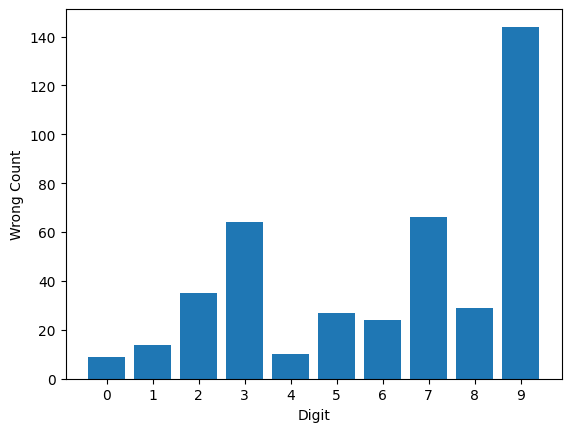

In [46]:
def test():
    correct = 0
    total = 0 

    wrong_counts = [0 for i in range(10)]

    with torch.no_grad():
        for data in tqdm(test_loader, desc='Testing'):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            output = net(x)
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    correct += 1
                else:
                    wrong_counts[y[idx]] += 1
                total += 1
    print(f'Accuracy: {round(correct/total, 3)}')
    for i in range(len(wrong_counts)):
        print(f'wrong counts for digit {i}: {wrong_counts[i]}')
    
    plt.bar(range(10), wrong_counts)
    plt.xticks(range(10))
    plt.xlabel("Digit")
    plt.ylabel("Wrong Count")
    plt.show()

test()

Here you can see the original parameter count before LoRA

In [48]:
total_parameters_original = 0
for index, layer in enumerate([net.linear1, net.linear2, net.linear3]):
    total_parameters_original += layer.weight.nelement() + layer.bias.nelement()
    print(f'Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape}')
print(f'Total number of parameters: {total_parameters_original:,}')

Layer 1: W: torch.Size([1000, 784]) + B: torch.Size([1000])
Layer 2: W: torch.Size([2000, 1000]) + B: torch.Size([2000])
Layer 3: W: torch.Size([10, 2000]) + B: torch.Size([10])
Total number of parameters: 2,807,010


Define the LoRA parameterization as described in the paper. The full detail on how PyTorch parameterizations work is here: \
 https://pytorch.org/tutorials/intermediate/parametrizations.html

In [49]:
class LoRAParametrization(nn.Module):
    def __init__(self, features_in, features_out, rank=1, alpha=1, device='cpu'):
        super().__init__()
        # Section 4.1 of the paper:
        #  We use random Gaussian initialization for A and zero for B, so ΔW = BA is zero ate the beginning of training
        self.lora_A = nn.Parameter(torch.zeros((rank, features_out)).to(device))
        self.lora_B = nn.Parameter(torch.zeros((features_in, rank)).to(device))
        nn.init.normal_(self.lora_A, mean=0, std=1)

        # Section 4.1 of the paper:
        #  We then scale ΔWx by α/r , where α is a constant in r.
        #  When optimizing with Adam, tuning α is roughly the same as tuning the learning rate if we scale the initialization appropriately.
        #  As a result, we simply set α to the first r we try and do not tune it. 
        #  This scaling helps to reduce the need to retune hyperparameters when we vary r.
        self.scale = alpha / rank 
        self.enabled = True

    def forward(self, original_weights):
        if self.enabled:
            # Return W + (B*A)*scale 
            return original_weights + torch.matmul(self.lora_B, self.lora_A).view(original_weights.shape) * self.scale 
        else: 
            return original_weights

Add the parameterization to the network

In [50]:
import torch.nn.utils.parametrize as parametrize

def linear_layer_parameterization(layer, device, rank=1, lora_alpha=1):
    features_in, features_out = layer.weight.shape 
    return LoRAParametrization(
        features_in, features_out, rank=rank, alpha=lora_alpha, device=device
    )

parametrize.register_parametrization(
    net.linear1, "weight", linear_layer_parameterization(net.linear1, device)
)
parametrize.register_parametrization(
    net.linear2, "weight", linear_layer_parameterization(net.linear2, device)
)
parametrize.register_parametrization(
    net.linear3, "weight", linear_layer_parameterization(net.linear3, device)
)

def enable_disable_lora(enabled=True):
    for layer in [net.linear1, net.linear2, net.linear3]:
        layer.parametrizations["weight"][0].enabled = enabled 

Display shapes of B and A of each layer. shape(BA) will match shape(W)

In [51]:
for layer in [net.linear1, net.linear2, net.linear3]:
    print(layer.parametrizations["weight"][0].lora_A.shape)
    print(layer.parametrizations["weight"][0].lora_B.shape)

torch.Size([1, 784])
torch.Size([1000, 1])
torch.Size([1, 1000])
torch.Size([2000, 1])
torch.Size([1, 2000])
torch.Size([10, 1])


Display the number of parameters added by LoRA

In [52]:
total_parameters_lora = 0
total_parameters_non_lora = 0
for index, layer in enumerate([net.linear1, net.linear2, net.linear3]):
    total_parameters_lora += layer.parametrizations["weight"][0].lora_A.nelement() + layer.parametrizations["weight"][0].lora_B.nelement()
    total_parameters_non_lora += layer.weight.nelement() + layer.bias.nelement()
    print(
        f'Layer {index+1}: W {layer.weight.shape} + B: {layer.bias.shape} + Lora_A: {layer.parametrizations["weight"][0].lora_A.shape} + Lora_B: {layer.parametrizations["weight"][0].lora_B.shape}'
    )

# The non-LoRA parameter count must match the original network
assert total_parameters_non_lora == total_parameters_original
print(f'Total number of parameters (original): {total_parameters_non_lora:,}')
print(f'Total number of parameters (original + LoRA): {total_parameters_lora + total_parameters_non_lora:,}')
print(f'Parameters introduced by LoRA: {total_parameters_lora:,}')
parameters_incremment = (total_parameters_lora / total_parameters_non_lora) * 100
print(f'Parameters incremment: {parameters_incremment:.3f}%')

Layer 1: W torch.Size([1000, 784]) + B: torch.Size([1000]) + Lora_A: torch.Size([1, 784]) + Lora_B: torch.Size([1000, 1])
Layer 2: W torch.Size([2000, 1000]) + B: torch.Size([2000]) + Lora_A: torch.Size([1, 1000]) + Lora_B: torch.Size([2000, 1])
Layer 3: W torch.Size([10, 2000]) + B: torch.Size([10]) + Lora_A: torch.Size([1, 2000]) + Lora_B: torch.Size([10, 1])
Total number of parameters (original): 2,807,010
Total number of parameters (original + LoRA): 2,813,804
Parameters introduced by LoRA: 6,794
Parameters incremment: 0.242%


Freeze all the parameters of the original network and only update the weights introduced by LoRA during fine-tuning on the digit 9

In [54]:
# Freeze non-LoRA parameters
for name, param in net.named_parameters():
    if 'lora' not in name:
        print(f'Freezing non-LoRA parameter {name}')
        param.requires_grad = False 

# Load MNIST again but only keep digit 9
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
exclude_indices = mnist_trainset.targets == 9 
mnist_trainset.data = mnist_trainset.data[exclude_indices]
mnist_trainset.targets = mnist_trainset.targets[exclude_indices]

train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=10, shuffle=True)

train(train_loader, net, epochs=1, total_iterations_limit=100)

Freezing non-LoRA parameter linear1.bias
Freezing non-LoRA parameter linear1.parametrizations.weight.original
Freezing non-LoRA parameter linear2.bias
Freezing non-LoRA parameter linear2.parametrizations.weight.original
Freezing non-LoRA parameter linear3.bias
Freezing non-LoRA parameter linear3.parametrizations.weight.original


Epoch 1:  99%|█████████▉| 99/100 [00:01<00:00, 93.77it/s, loss=0.107] 


Verify that the fine-tuning didn't alter the original weights, but only the ones introduced by LoRA

In [62]:
# Check that the frozen parameters are still unchanged by the finetuning
assert torch.all(net.linear1.parametrizations.weight.original == original_weights['linear1.weight'])
assert torch.all(net.linear2.parametrizations.weight.original == original_weights['linear2.weight'])
assert torch.all(net.linear3.parametrizations.weight.original == original_weights['linear3.weight'])

enable_disable_lora(enabled=True)
# The new linear1.weight is obtained by the "forward" function of our LoRA parametrization
# The original weights have been moved to net.linear1.parametrizations.weight.original
# More info here: https://pytorch.org/tutorials/intermediate/parametrizations.html#inspecting-a-parametrized-module
assert torch.equal(net.linear1.weight, net.linear1.parametrizations.weight.original + (net.linear1.parametrizations.weight[0].lora_B @ net.linear1.parametrizations.weight[0].lora_A) * net.linear1.parametrizations.weight[0].scale)

enable_disable_lora(enabled=False)
# If we disable LoRA, the linear1.weight is the original one
assert torch.equal(net.linear1.weight, original_weights['linear1.weight'])

Test the network with LoRA enabled 

Testing: 100%|██████████| 1000/1000 [00:05<00:00, 171.66it/s]


Accuracy: 0.889
wrong counts for digit 0: 14
wrong counts for digit 1: 15
wrong counts for digit 2: 55
wrong counts for digit 3: 106
wrong counts for digit 4: 352
wrong counts for digit 5: 86
wrong counts for digit 6: 42
wrong counts for digit 7: 346
wrong counts for digit 8: 84
wrong counts for digit 9: 13


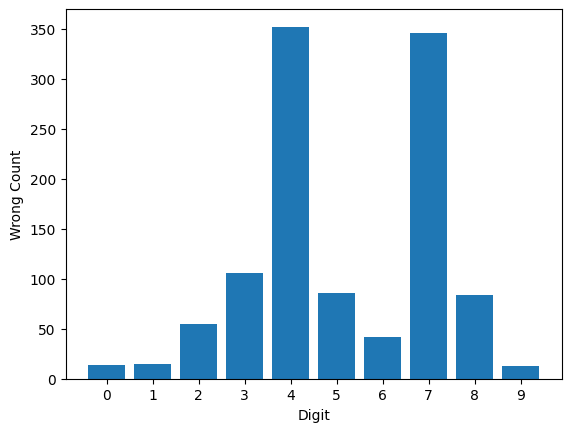

In [63]:
enable_disable_lora(enabled=True)
test()

Test with LoRA diabled (result should be the same as in the original model)

Testing: 100%|██████████| 1000/1000 [00:05<00:00, 189.24it/s]


Accuracy: 0.958
wrong counts for digit 0: 9
wrong counts for digit 1: 14
wrong counts for digit 2: 35
wrong counts for digit 3: 64
wrong counts for digit 4: 10
wrong counts for digit 5: 27
wrong counts for digit 6: 24
wrong counts for digit 7: 66
wrong counts for digit 8: 29
wrong counts for digit 9: 144


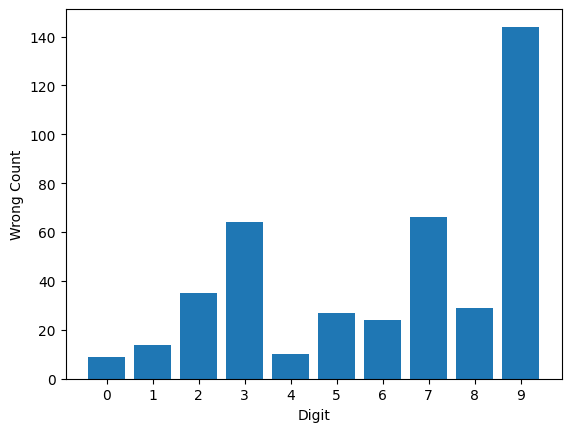

In [64]:
enable_disable_lora(enabled=False)
test()